In [1]:
!pip install datasets
!pip install transformers
!pip install torch
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.3 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import numpy as np
import torch
from tqdm.auto import tqdm
from torch.optim import AdamW

dataset = load_dataset("emotion", cache_dir="./data")
train_data = dataset["train"]
test_data = dataset["test"]
seed = 10

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
mini_train = tokenized_train.shuffle(seed=seed).select(range(2000))
mini_test = tokenized_test.shuffle(seed=seed).select(range(1000))

In [6]:
from torch.utils.data import DataLoader
import torch

def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
        'labels': torch.tensor([item['label'] for item in batch])
    }

train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=8, collate_fn=collate_fn)
test_dataloader = DataLoader(tokenized_test, batch_size=8, collate_fn=collate_fn)

mini_test_dataloader = DataLoader(mini_test, batch_size=8, collate_fn=collate_fn)
mini_train_dataloader = DataLoader(mini_train, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [7]:
from transformers import BertForSequenceClassification

num_labels = len(train_data.features["label"].names)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def evaluate_acc(y_hat: np.ndarray, y: np.ndarray):
    print(y_hat.shape, y.shape)
    return np.sum(y_hat == y) / y.size

In [9]:
def encode_y(y: np.ndarray):
    y = y.reshape(-1, 1)
    y_encoded = np.zeros((len(y), num_labels))
    for i in range(num_labels):
        y_encoded[:, i] = (y == i).reshape(-1)
    return y_encoded

In [10]:
def compute_F1(y_hat, y):
    y_encoded = encode_y(y)
    y_hat_encoded = encode_y(y_hat)
    J = np.zeros((y_encoded.shape[1], 1))
    P = np.zeros((y_encoded.shape[1], 1)) # Precision
    R = np.zeros((y_encoded.shape[1], 1)) # Recall
    for i in range(y_encoded.shape[1]):
        y_column = y_encoded[:, i]
        y_hat_column = y_hat_encoded[:, i]
        y_true = y_column == 1
        y_hat_true = y_hat_column==1
        true_positives = np.sum((y_true==1) & (y_hat_true==1))
        false_positives = np.sum((y_true==0) & (y_hat_true==1))
        false_negatives = np.sum((y_true==1) & (y_hat_true==0))
        epsilon = 1e-8
        precision = float(true_positives) / float(true_positives + false_positives + epsilon)
        recall = float(true_positives) / float(true_positives + false_negatives + epsilon)
        F1 = (2 * precision * recall) / (precision + recall + epsilon)
        J[i] = F1
        P[i] = precision
        R[i] = recall
    return J, P, R

In [11]:
def test_model(current_model, current_dataloader):
    current_model.to(device)
    current_model.eval()
    y_true = []
    y_hat = []
    with torch.no_grad():
        for batch in tqdm(current_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = current_model(**batch)
            logits = outputs.logits
            yh = logits.argmax(dim=1).cpu().numpy()
            yh = yh.tolist()
            y_hat.extend(yh)
            y_val = batch["labels"].cpu().numpy()
            y_val = y_val.tolist()
            y_true.extend(y_val)
    y_hat = np.array(y_hat)
    y_true = np.array(y_true)
    acc = evaluate_acc(y_hat, y_true)
    J, P, R = compute_F1(y_hat, y_true)
    return acc, J, P, R

In [12]:
# Create untrained copy of model
model_untrained = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels).to(device)
acc, f1, precision, recall = test_model(model_untrained, test_dataloader)

print(f"Untrained model accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Untrained model accuracy: 0.112, F1: [[0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.2018018]
 [0.       ]], Precision: [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.11222445]
 [0.        ]], Recall: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]


In [13]:
initial_acc = acc
initial_f1 = f1
initial_precision = precision
initial_recall = recall

In [14]:
acc_list = [initial_acc.tolist()]
f1_list = [initial_f1.tolist()]
precision_list = [initial_precision.tolist()]
recall_list = [initial_recall.tolist()]

In [15]:
def fit(fit_model, fit_dataloader, check_dataloader, optimizer, epochs=3):
    torch.cuda.empty_cache()
    fit_model.to(device)
    for epoch in range(epochs):  # number of epochs
        fit_model.train()
        for batch in tqdm(fit_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = fit_model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        acc, f1, precision, recall = test_model(fit_model, check_dataloader)
        acc_list.append(acc.tolist())
        f1_list.append([f1.tolist()])
        precision_list.append([precision.tolist()])
        recall_list.append([recall.tolist()])
        print(f"Epoch {epoch+1}: Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

In [16]:
optimizer = AdamW(model.parameters(), lr=5e-5)
fit(model, mini_train_dataloader, test_dataloader, optimizer, epochs=3)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Epoch 1: Accuracy: 0.803, F1: [[0.84736355]
 [0.88961892]
 [0.41904762]
 [0.76171079]
 [0.71232876]
 [0.57142857]], Precision: [[0.916     ]
 [0.81862152]
 [0.8627451 ]
 [0.86574074]
 [0.57777778]
 [0.69565217]], Recall: [[0.78829604]
 [0.97410072]
 [0.27672956]
 [0.68      ]
 [0.92857143]
 [0.48484848]]


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Epoch 2: Accuracy: 0.8815, F1: [[0.91681109]
 [0.91340782]
 [0.7615894 ]
 [0.8647619 ]
 [0.84892086]
 [0.71764705]], Precision: [[0.92321117]
 [0.88738128]
 [0.8041958 ]
 [0.908     ]
 [0.91709845]
 [0.58653846]], Recall: [[0.91049914]
 [0.94100719]
 [0.72327044]
 [0.82545455]
 [0.79017857]
 [0.92424242]]


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Epoch 3: Accuracy: 0.875, F1: [[0.91355932]
 [0.90882986]
 [0.71299093]
 [0.87971274]
 [0.82383419]
 [0.73202614]], Precision: [[0.89983306]
 [0.90687679]
 [0.68604651]
 [0.86879433]
 [0.98148148]
 [0.64367816]], Recall: [[0.92771084]
 [0.91079137]
 [0.74213836]
 [0.89090909]
 [0.70982143]
 [0.84848485]]


In [17]:
acc_np = np.zeros((4, 1))
recall_np = np.zeros((4, 6))
f1_np = np.zeros((4, 6))
precision_np = np.zeros((4, 6))

for i in range(4):
  acc_np[i] = np.array(acc_list[i])
  recall_np[i, :] = np.array(recall_list[i]).reshape((-1))
  f1_np[i, :] = np.array(f1_list[i]).reshape((-1))
  precision_np[i, :] = np.array(precision_list[i]).reshape((-1))



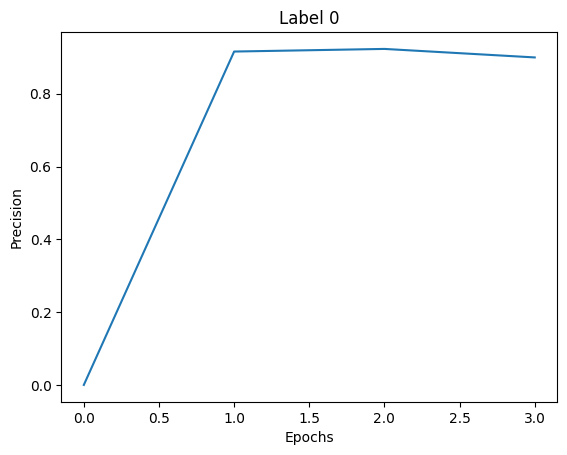

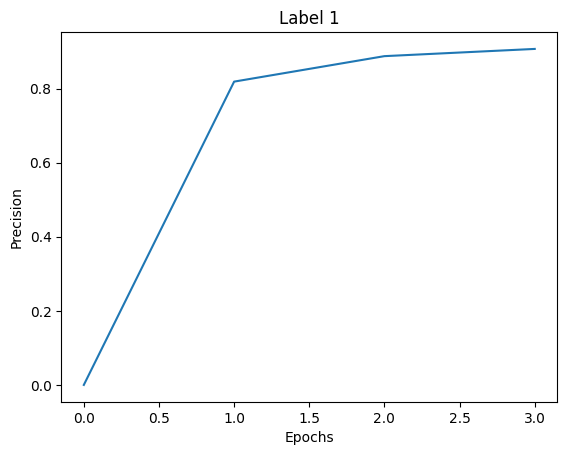

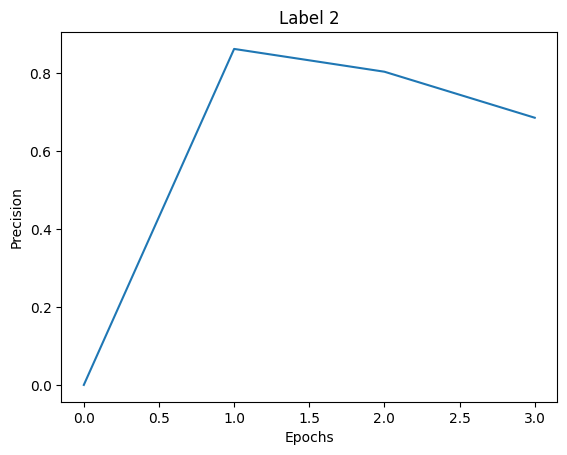

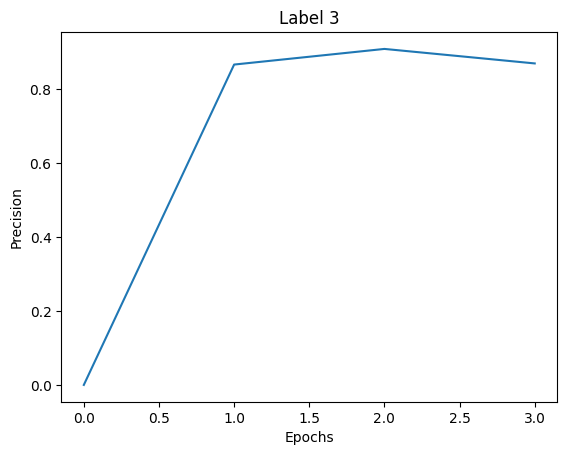

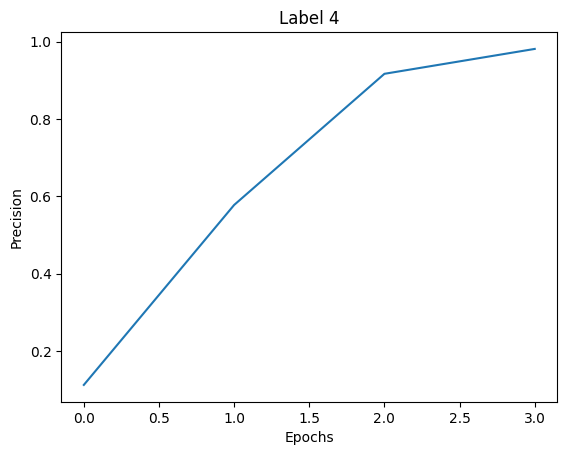

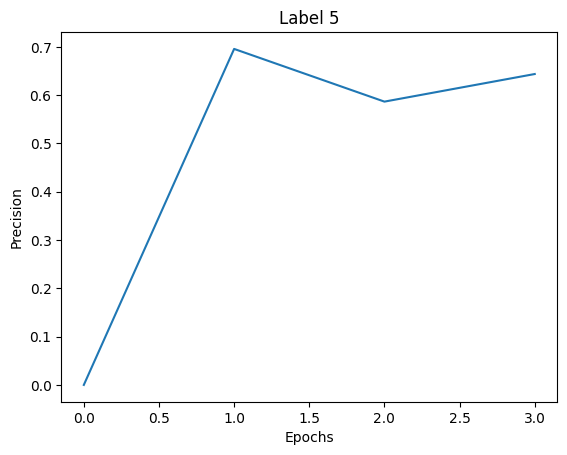

In [18]:
import matplotlib.pyplot as plt
for i in range(6):
  plt.plot(precision_np[:, i])
  plt.xlabel("Epochs")
  plt.ylabel("Precision")
  plt.title(f"Label {i}")
  plt.show()

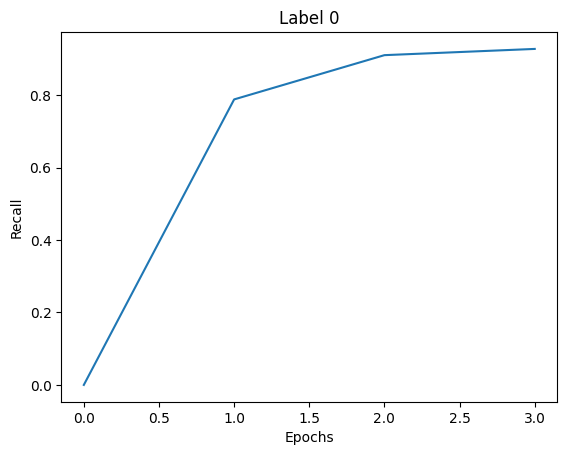

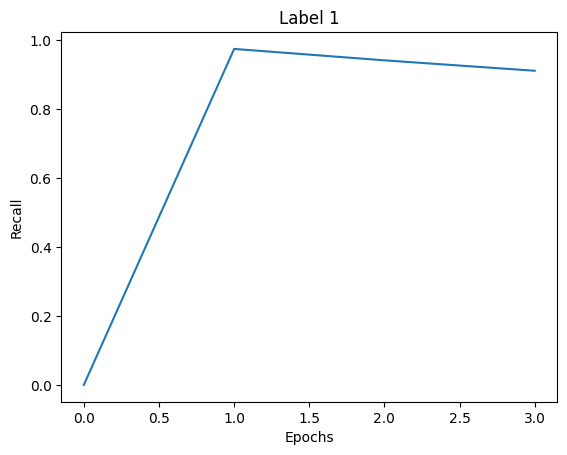

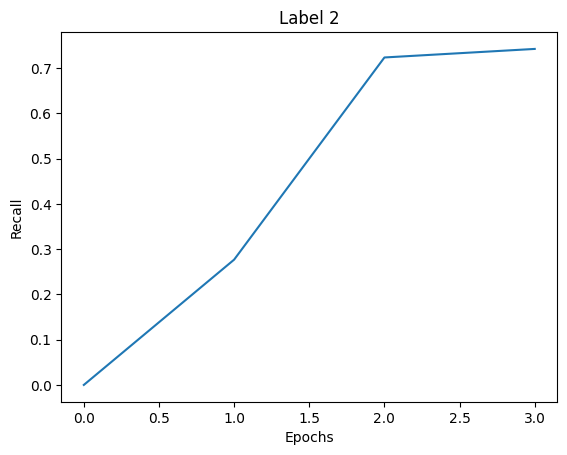

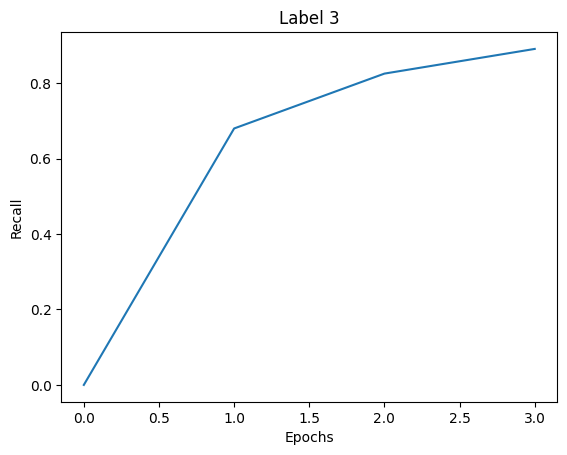

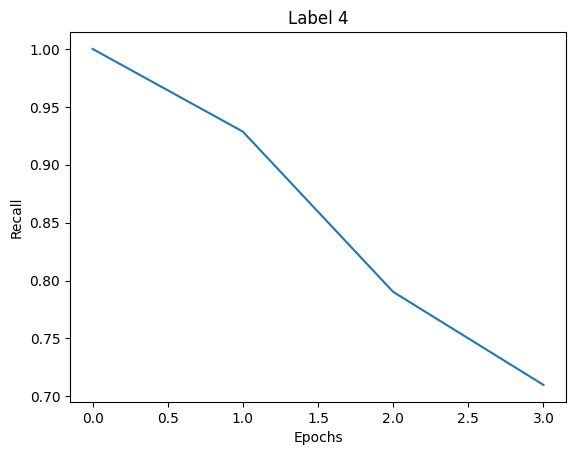

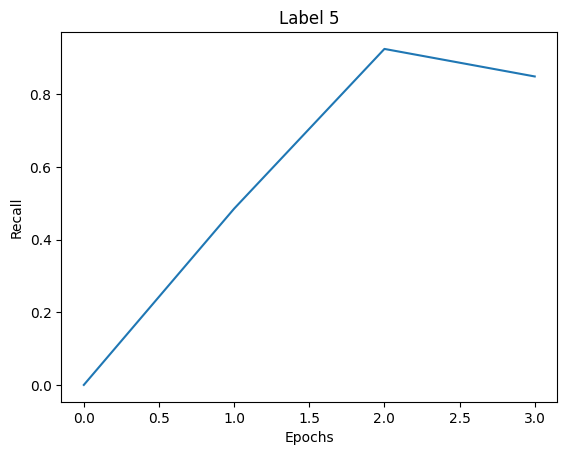

In [19]:
for i in range(6):
  plt.plot(recall_np[:, i])
  plt.xlabel("Epochs")
  plt.ylabel("Recall")
  plt.title(f"Label {i}")
  plt.show()

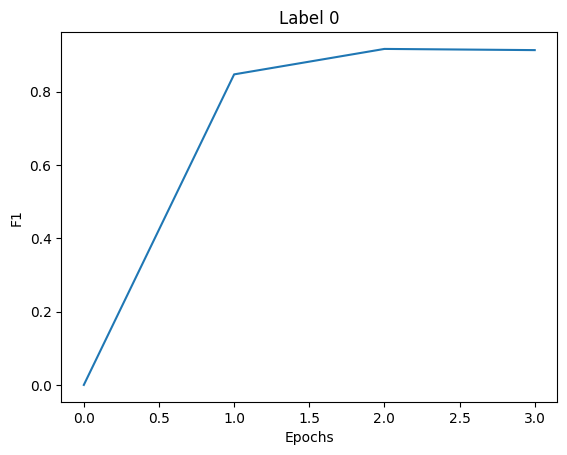

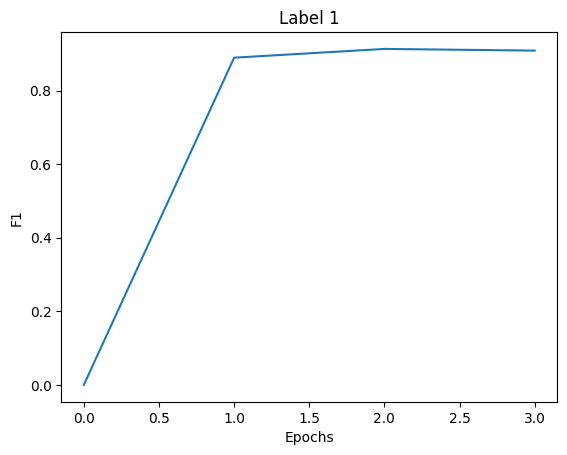

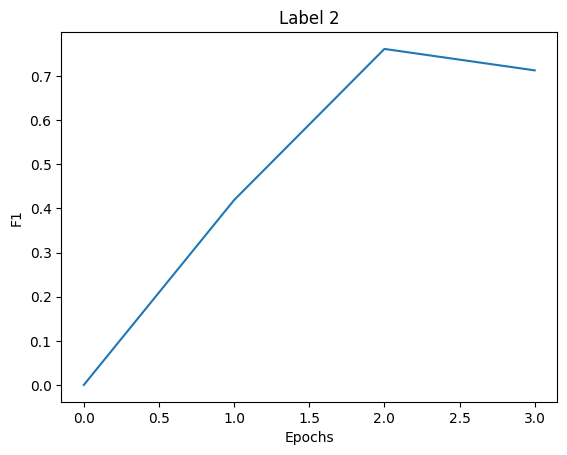

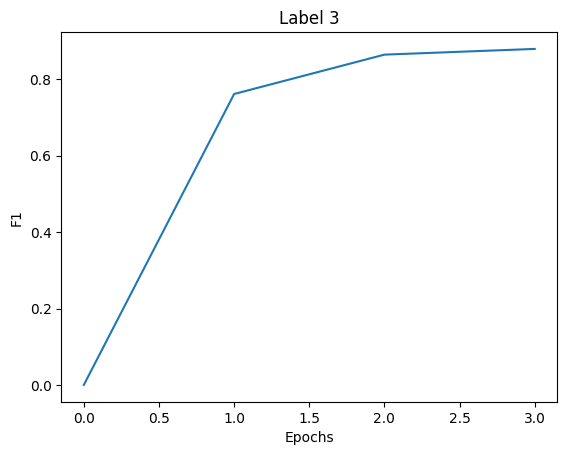

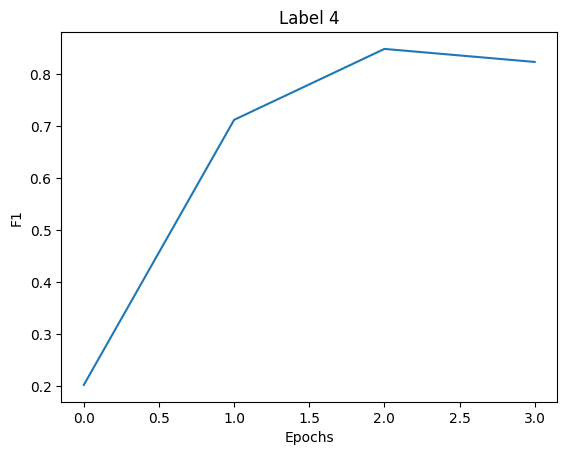

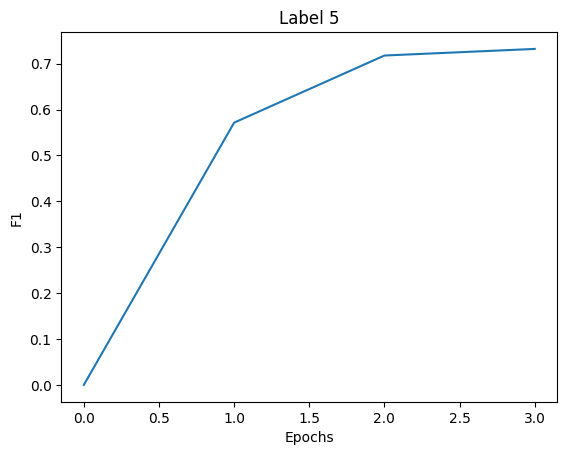

In [20]:
for i in range(6):
  plt.plot(f1_np[:, i])
  plt.xlabel("Epochs")
  plt.ylabel("F1")
  plt.title(f"Label {i}")
  plt.show()

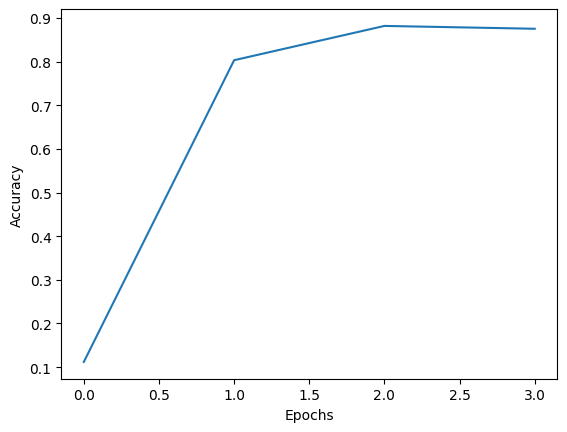

In [21]:
plt.plot(acc_np)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
# acc_np

In [22]:
torch.save(model.state_dict(), 'model_trained_default.pt')


In order to understand the effect of  using a pre-trained model, we use Kaiming initialization on the same model structure.

In [23]:
def kaiming(module):
    if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
        torch.nn.init.kaiming_normal_(module.weight.data, nonlinearity='relu')

In [24]:
kaiming_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
kaiming_model.apply(kaiming)
kaiming_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [25]:
# Create untrained copy of model
acc, f1, precision, recall = test_model(kaiming_model, test_dataloader)

print(f"Untrained model accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Untrained model accuracy: 0.292, F1: [[0.4181908 ]
 [0.2731439 ]
 [0.        ]
 [0.        ]
 [0.06217616]
 [0.        ]], Precision: [[0.29334258]
 [0.37626263]
 [0.        ]
 [0.        ]
 [0.07407407]
 [0.        ]], Recall: [[0.72805508]
 [0.21438849]
 [0.        ]
 [0.        ]
 [0.05357143]
 [0.        ]]


In [26]:
acc_list = [acc.tolist()]
f1_list = [f1.tolist()]
precision_list = [precision.tolist()]
recall_list = [recall.tolist()]

In [27]:
optimizer = AdamW(kaiming_model.parameters(), lr=5e-5)
fit(kaiming_model, mini_train_dataloader, test_dataloader, optimizer, epochs=3)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Epoch 1: Accuracy: 0.2905, F1: [[0.45021309]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]], Precision: [[0.2905]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]], Recall: [[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Epoch 2: Accuracy: 0.2905, F1: [[0.45021309]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]], Precision: [[0.2905]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]], Recall: [[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Epoch 3: Accuracy: 0.3475, F1: [[0.        ]
 [0.51576994]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]], Precision: [[0.    ]
 [0.3475]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]], Recall: [[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [28]:
k_acc_np = np.zeros((4, 1))
k_recall_np = np.zeros((4, 6))
k_f1_np = np.zeros((4, 6))
k_precision_np = np.zeros((4, 6))

for i in range(4):
  k_acc_np[i] = np.array(acc_list[i])
  k_recall_np[i, :] = np.array(recall_list[i]).reshape((-1))
  k_f1_np[i, :] = np.array(f1_list[i]).reshape((-1))
  k_precision_np[i, :] = np.array(precision_list[i]).reshape((-1))

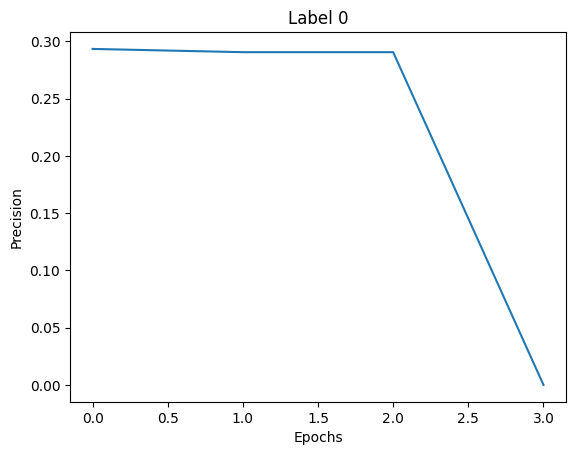

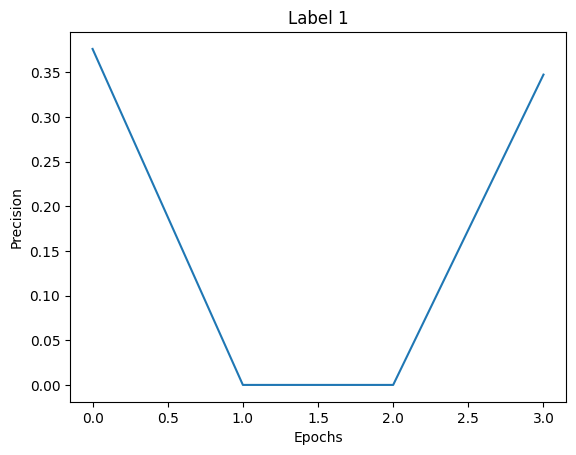

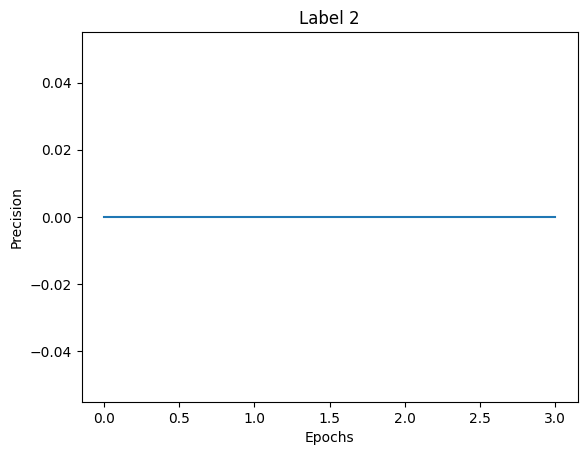

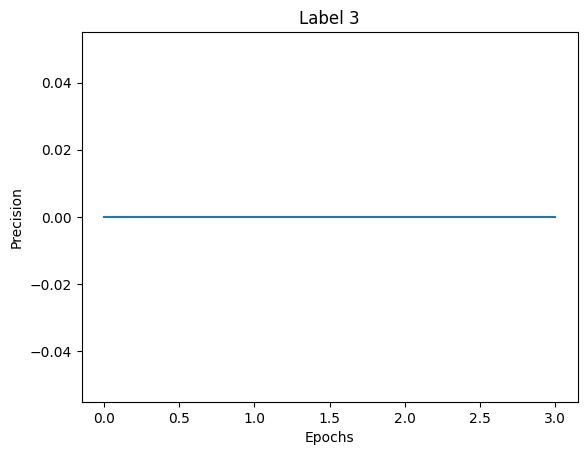

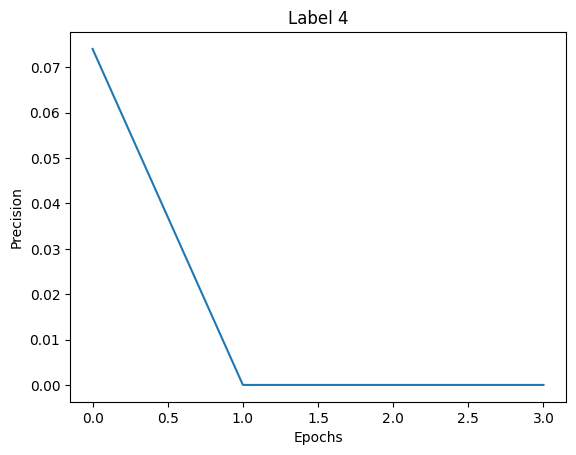

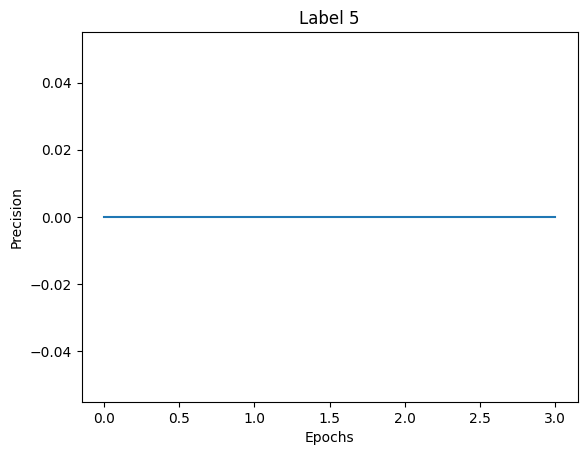

In [29]:
for i in range(6):
  plt.plot(k_precision_np[:, i])
  plt.xlabel("Epochs")
  plt.ylabel("Precision")
  plt.title(f"Label {i}")
  plt.show()

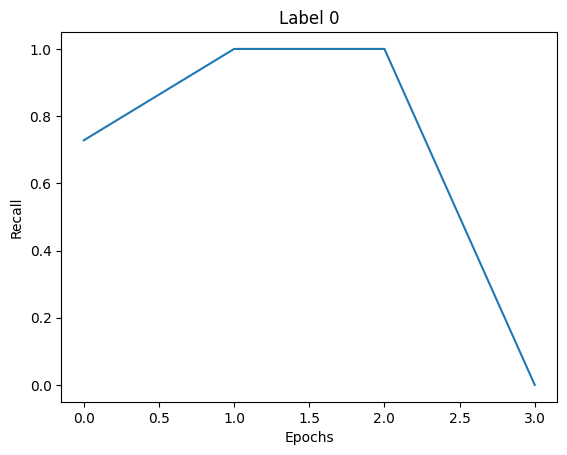

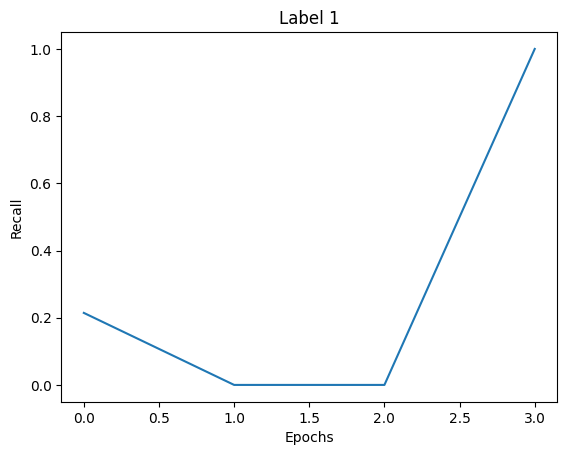

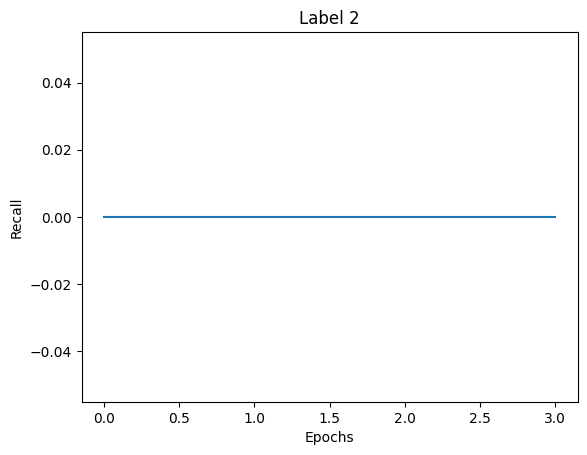

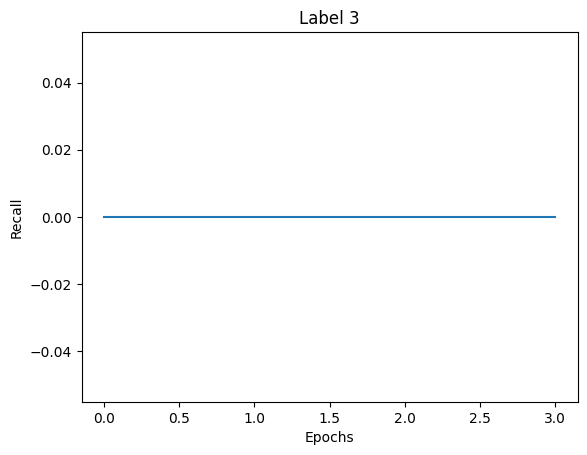

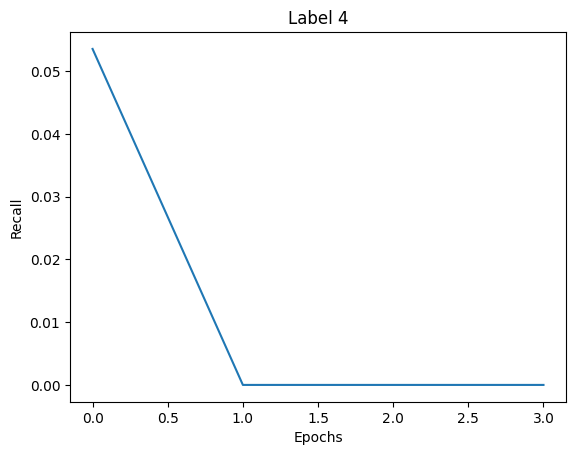

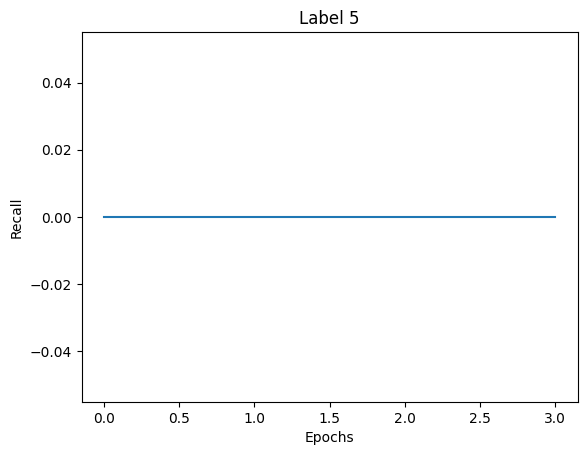

In [30]:
for i in range(6):
  plt.plot(k_recall_np[:, i])
  plt.xlabel("Epochs")
  plt.ylabel("Recall")
  plt.title(f"Label {i}")
  plt.show()

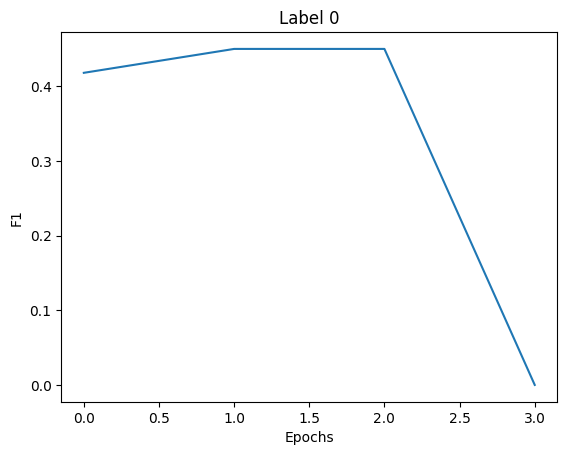

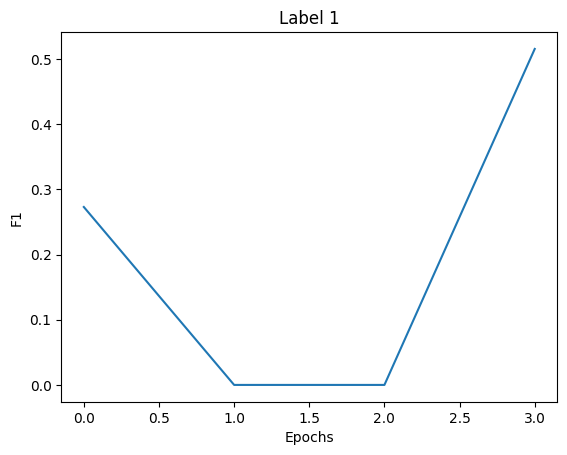

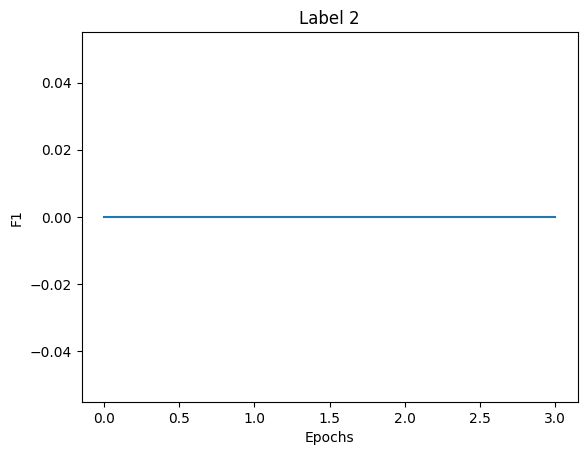

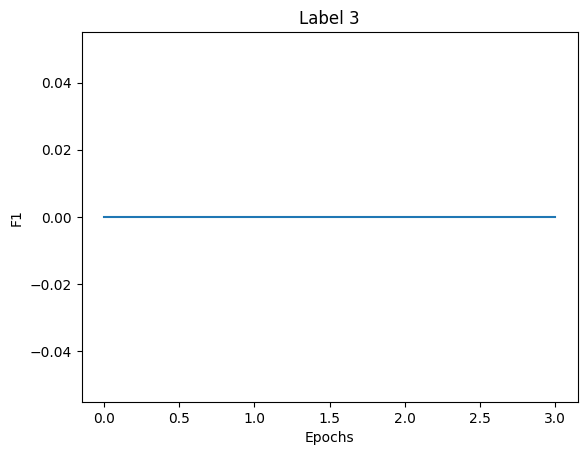

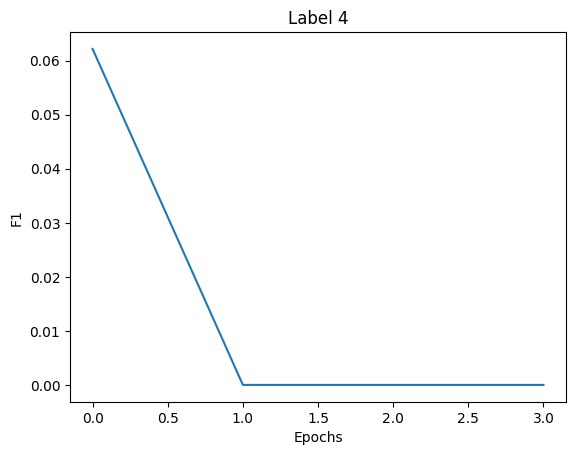

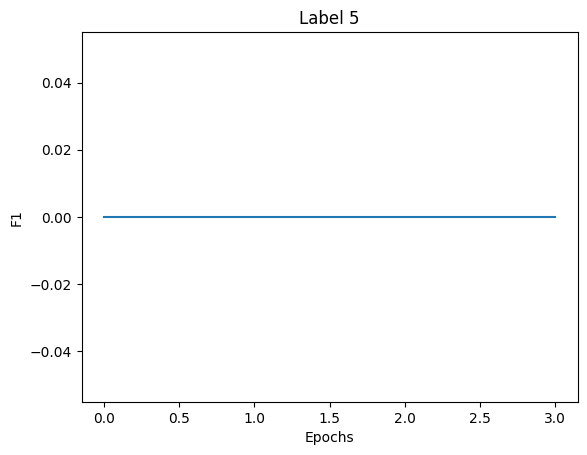

In [31]:
for i in range(6):
  plt.plot(k_f1_np[:, i])
  plt.xlabel("Epochs")
  plt.ylabel("F1")
  plt.title(f"Label {i}")
  plt.show()

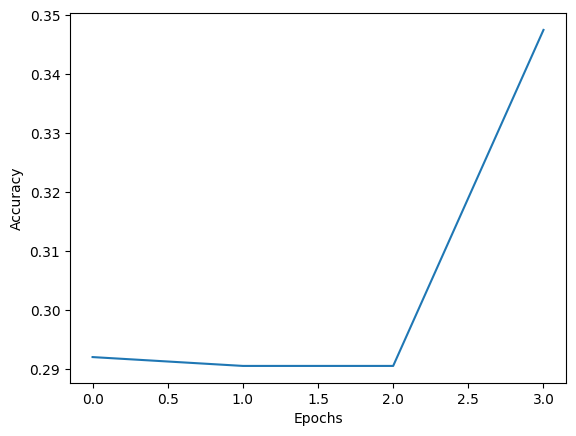

In [32]:
plt.plot(k_acc_np)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [33]:
torch.save(kaiming_model.state_dict(), 'kaiming_model_trained.pt')

We can clearly see that Kaiming initialization, while it does get better, is nowhere close to as good as the pre-trained model after the same amount of time.

We now change the model structure. From the previous 12 hidden layers, we hypothesize that since our dataset if small/simple, we should be able to obtain reasonably good results with 8 attention heads and 6 hidden layers.

In [34]:
config = model.config
config.num_hidden_layers = 6 # Default was 12
config.num_attention_heads = 8 # Default was 12
#Load pre-trained model with new config
model_new = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
# fit(model_new, mini_train_dataloader, test_dataloader, optimizer, epochs=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
acc, f1, precision, recall = test_model(model_new, test_dataloader)

print(f"Untrained model accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Untrained model accuracy: 0.3125, F1: [[0.        ]
 [0.50061855]
 [0.08391608]
 [0.        ]
 [0.        ]
 [0.        ]], Precision: [[0.        ]
 [0.35086705]
 [0.06666667]
 [0.        ]
 [0.        ]
 [0.        ]], Recall: [[0.        ]
 [0.87338129]
 [0.11320755]
 [0.        ]
 [0.        ]
 [0.        ]]


In [36]:
acc_list = [initial_acc.tolist()]
f1_list = [initial_f1.tolist()]
precision_list = [initial_precision.tolist()]
recall_list = [initial_recall.tolist()]

In [37]:
optimizer = AdamW(model_new.parameters(), lr=5e-5)
fit(model_new, mini_train_dataloader, test_dataloader, optimizer, epochs=3)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Epoch 1: Accuracy: 0.848, F1: [[0.88352027]
 [0.89055064]
 [0.63114754]
 [0.82733812]
 [0.80660377]
 [0.69863013]], Precision: [[0.88581315]
 [0.84407216]
 [0.90588235]
 [0.81850534]
 [0.855     ]
 [0.6375    ]], Recall: [[0.88123924]
 [0.94244604]
 [0.48427673]
 [0.83636364]
 [0.76339286]
 [0.77272727]]


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Epoch 2: Accuracy: 0.8835, F1: [[0.92239858]
 [0.91708723]
 [0.73248407]
 [0.87878787]
 [0.85314685]
 [0.69014084]], Precision: [[0.94575045]
 [0.91907514]
 [0.74193548]
 [0.81818182]
 [0.89268293]
 [0.64473684]], Recall: [[0.90017212]
 [0.91510791]
 [0.72327044]
 [0.94909091]
 [0.81696429]
 [0.74242424]]


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

(2000,) (2000,)
Epoch 3: Accuracy: 0.8835, F1: [[0.92972057]
 [0.91026561]
 [0.74418604]
 [0.88205128]
 [0.84976525]
 [0.57894736]], Precision: [[0.915     ]
 [0.90830946]
 [0.78873239]
 [0.83225806]
 [0.8960396 ]
 [0.6875    ]], Recall: [[0.94492255]
 [0.91223022]
 [0.70440252]
 [0.93818182]
 [0.80803571]
 [0.5       ]]


In [38]:
n_acc_np = np.zeros((4, 1))
n_recall_np = np.zeros((4, 6))
n_f1_np = np.zeros((4, 6))
n_precision_np = np.zeros((4, 6))

for i in range(4):
  n_acc_np[i] = np.array(acc_list[i])
  n_recall_np[i, :] = np.array(recall_list[i]).reshape((-1))
  n_f1_np[i, :] = np.array(f1_list[i]).reshape((-1))
  n_precision_np[i, :] = np.array(precision_list[i]).reshape((-1))

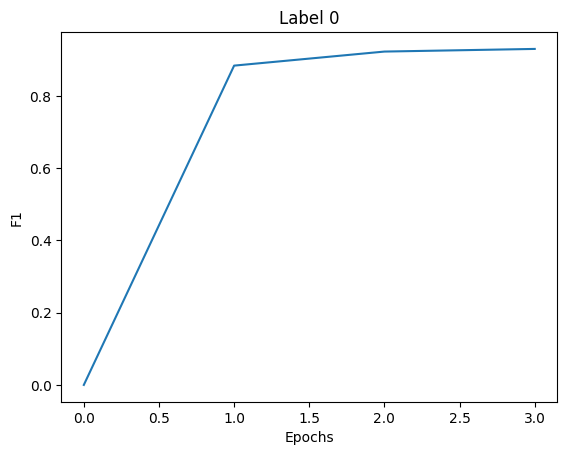

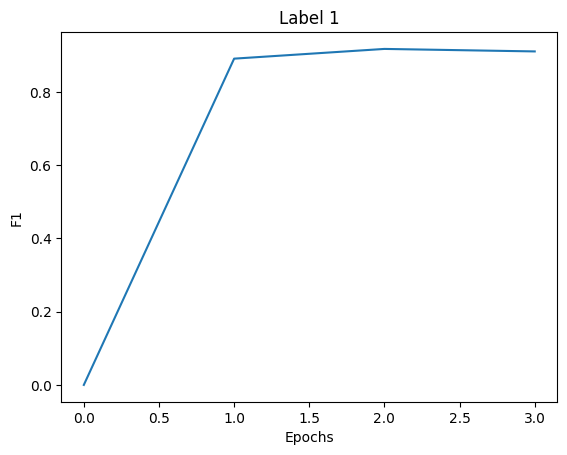

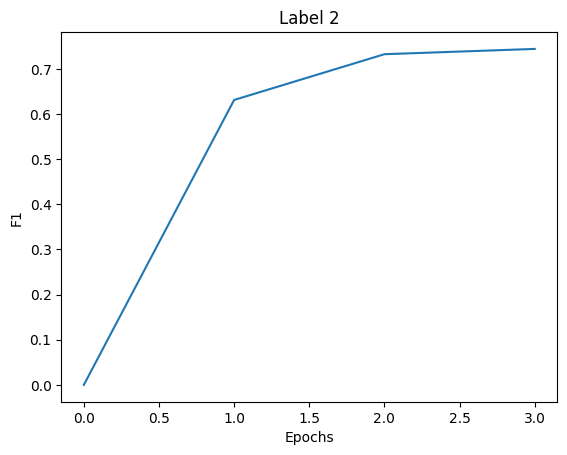

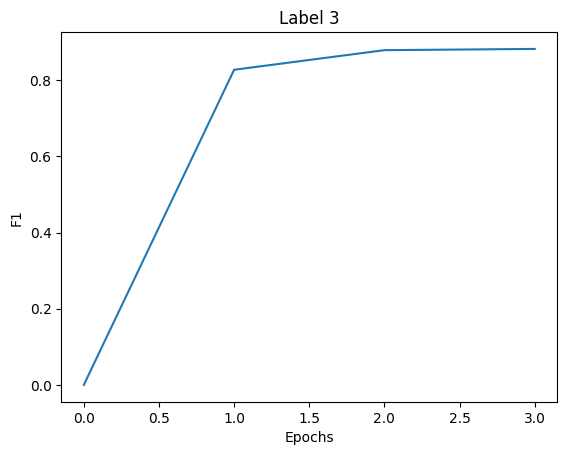

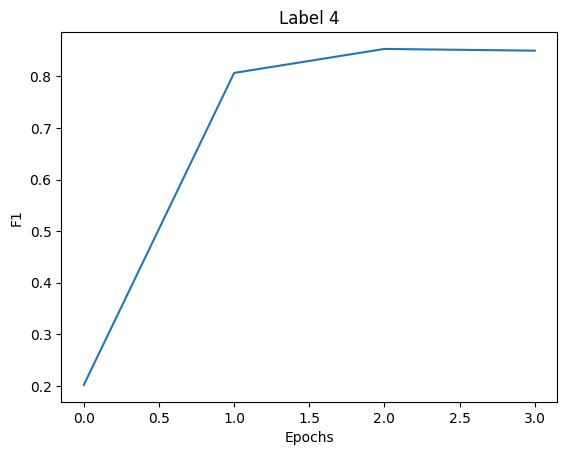

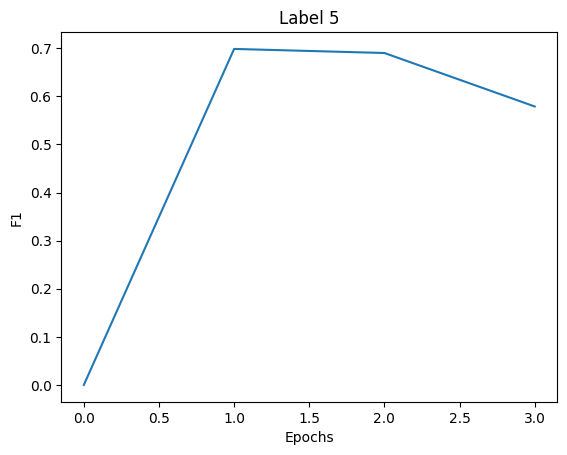

In [39]:
for i in range(6):
  plt.plot(n_f1_np[:, i])
  plt.xlabel("Epochs")
  plt.ylabel("F1")
  plt.title(f"Label {i}")
  plt.show()

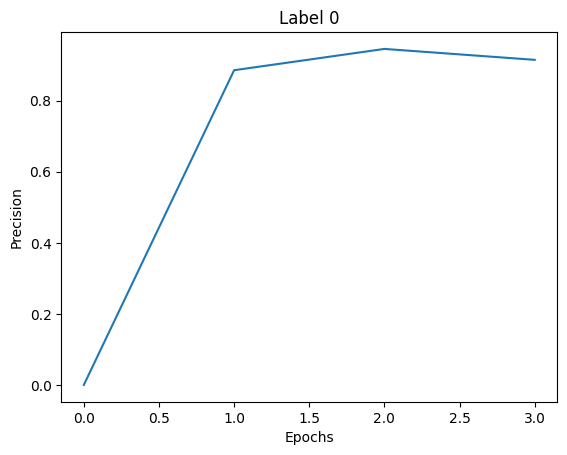

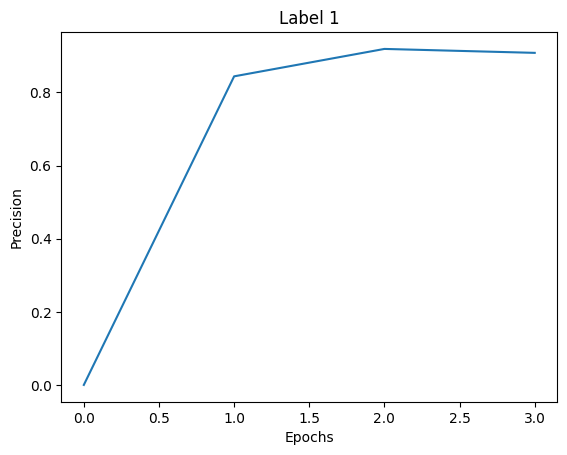

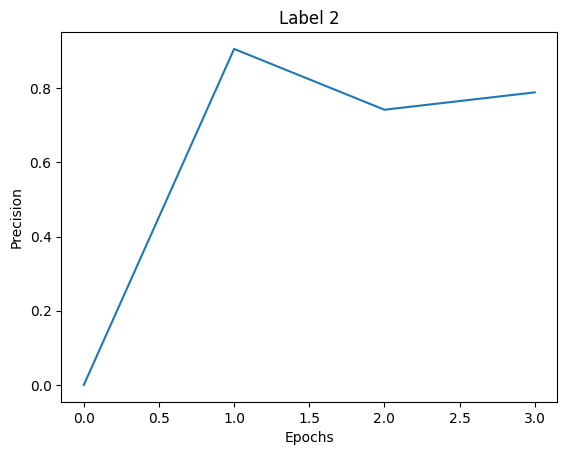

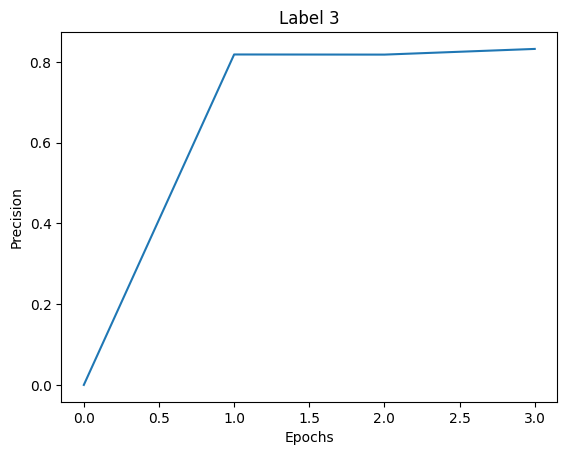

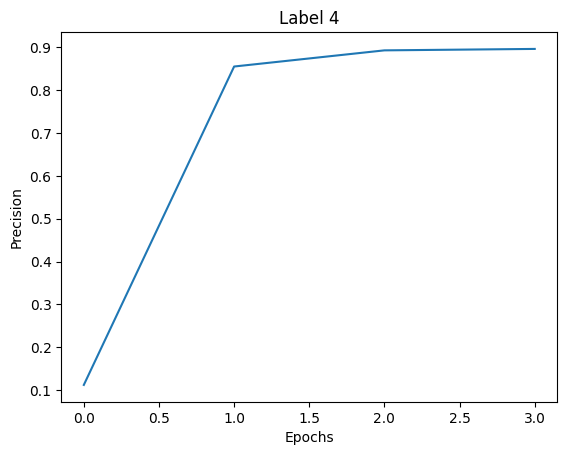

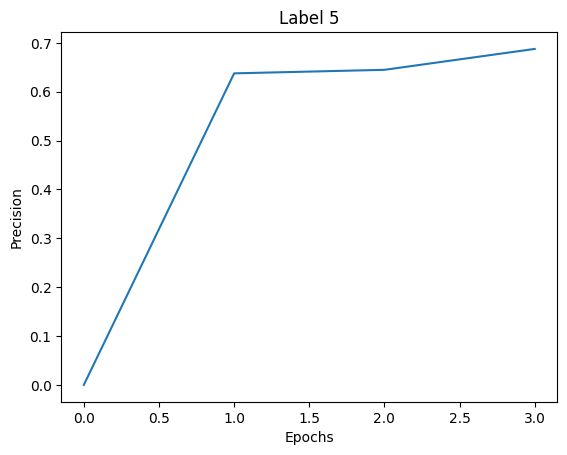

In [40]:
for i in range(6):
  plt.plot(n_precision_np[:, i])
  plt.xlabel("Epochs")
  plt.ylabel("Precision")
  plt.title(f"Label {i}")
  plt.show()

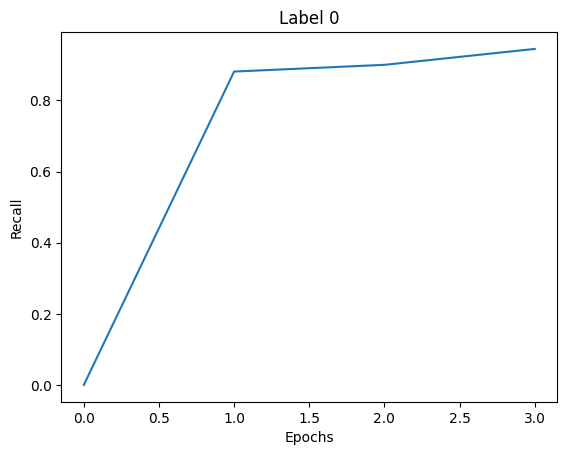

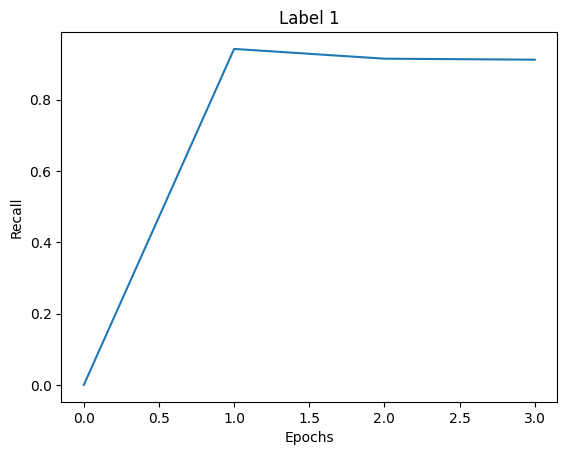

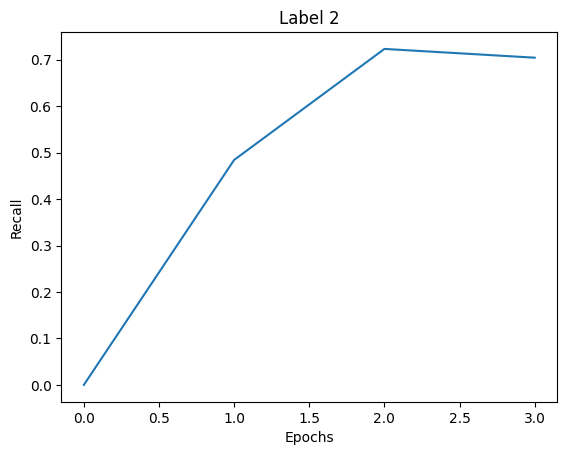

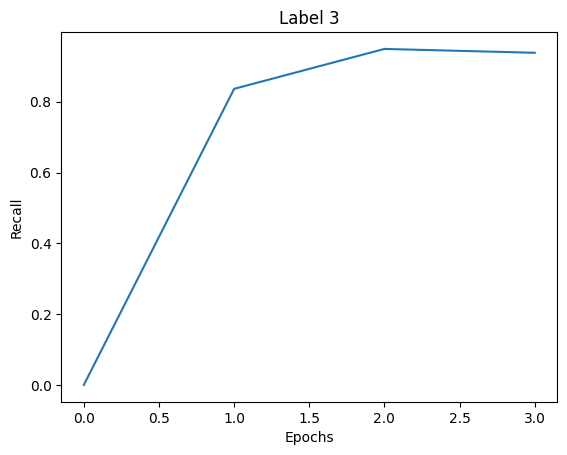

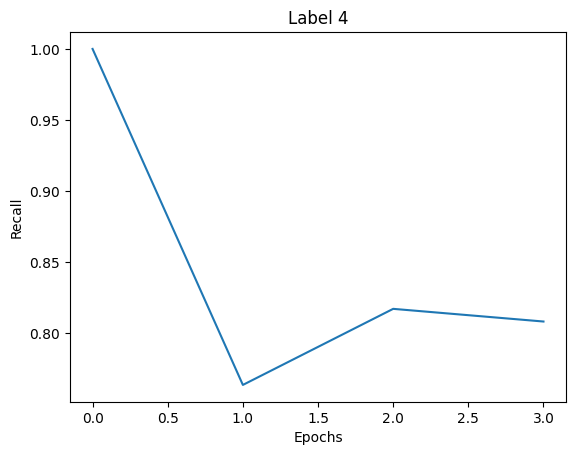

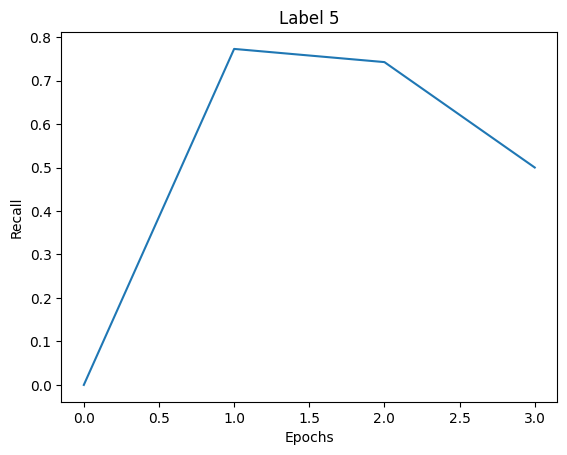

In [41]:
for i in range(6):
  plt.plot(n_recall_np[:, i])
  plt.xlabel("Epochs")
  plt.ylabel("Recall")
  plt.title(f"Label {i}")
  plt.show()

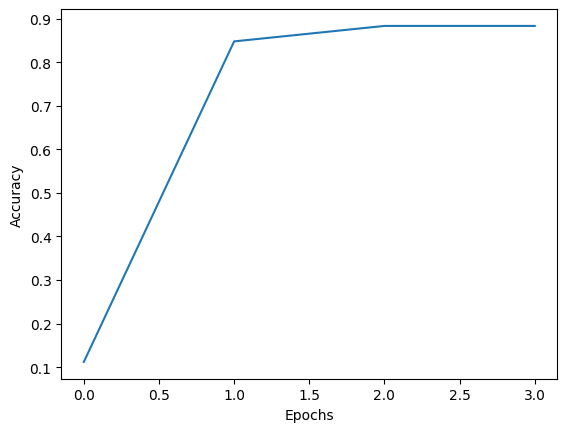

In [42]:
plt.plot(n_acc_np)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [43]:
# Save model
torch.save(model_new.state_dict(), 'model_new_6layers.pt')

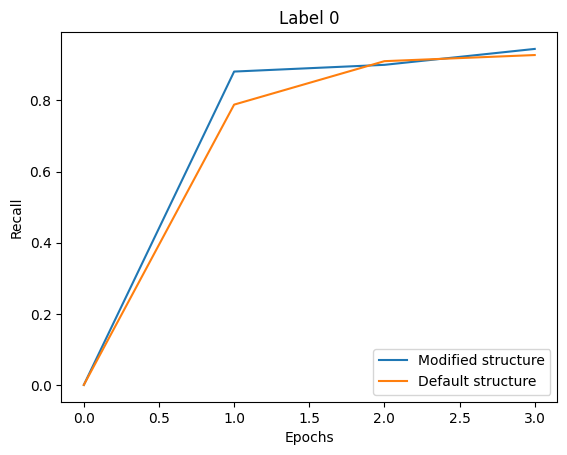

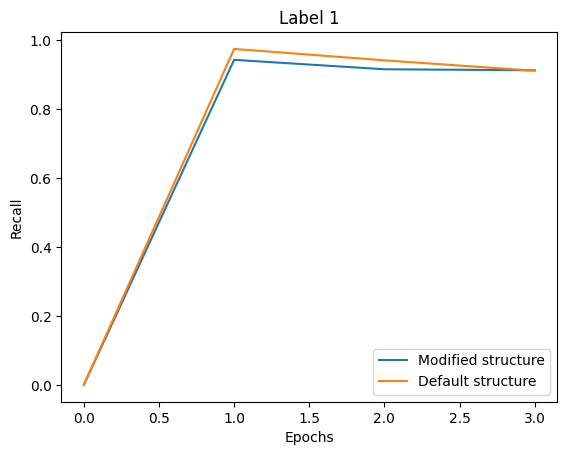

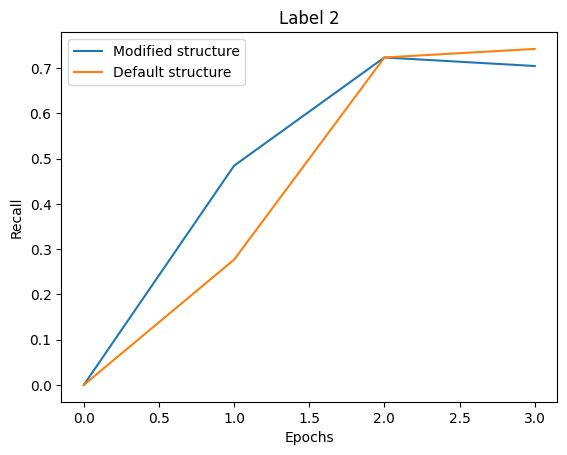

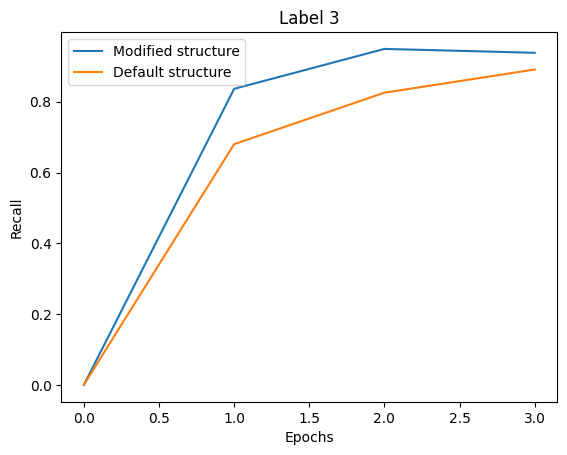

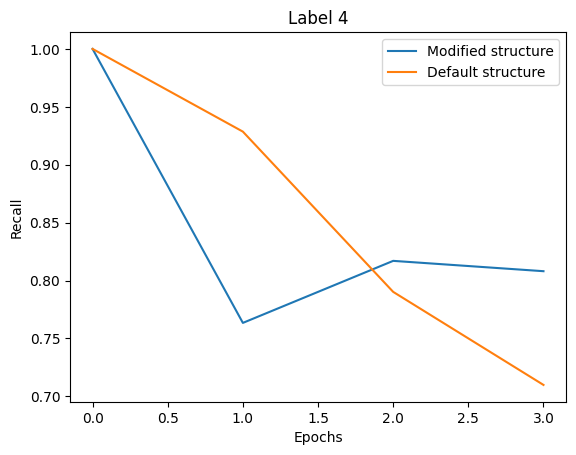

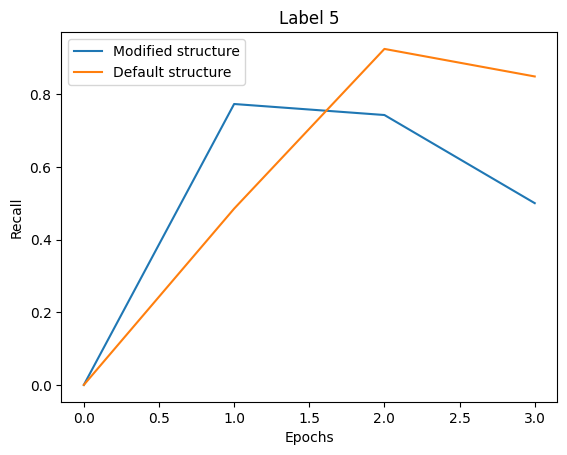

In [44]:
# Plot original and new recall
for i in range(6):
  plt.plot(n_recall_np[:, i], label="Modified structure")
  plt.plot(recall_np[:, i], label="Default structure")
  plt.xlabel("Epochs")
  plt.ylabel("Recall")
  plt.title(f"Label {i}")
  plt.legend()
  plt.show()

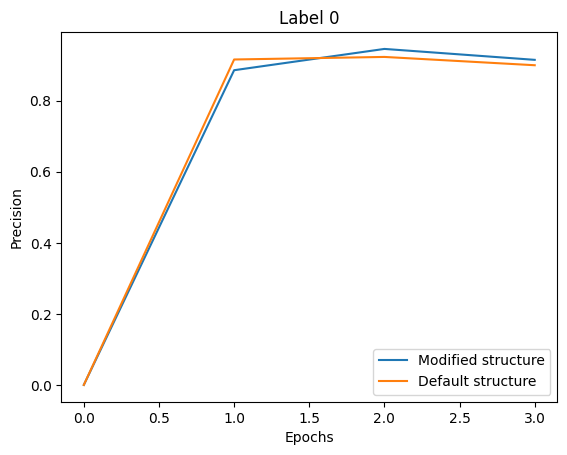

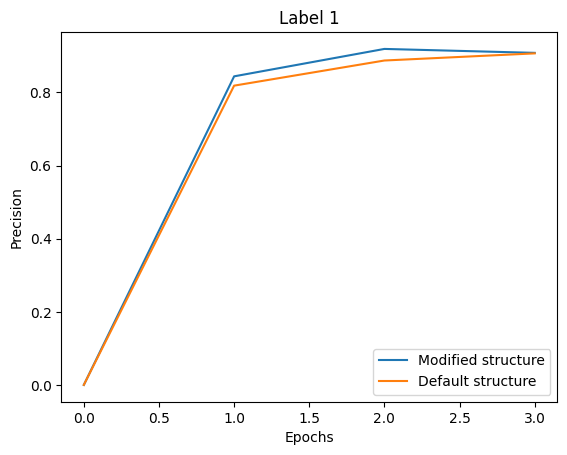

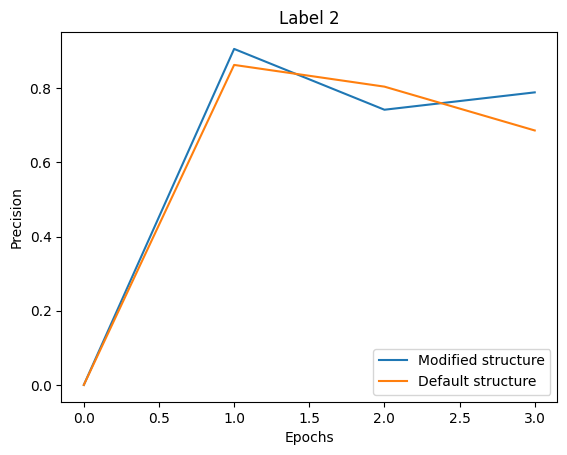

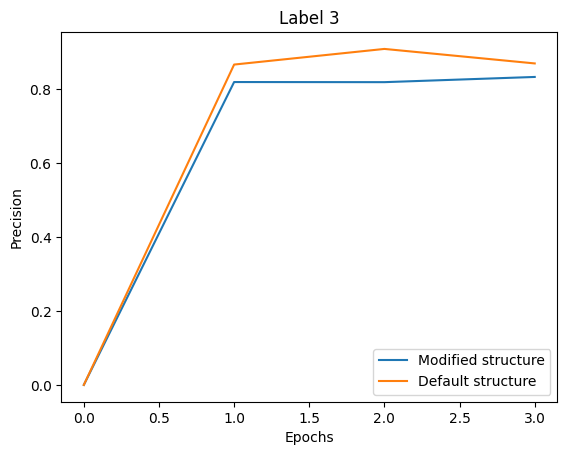

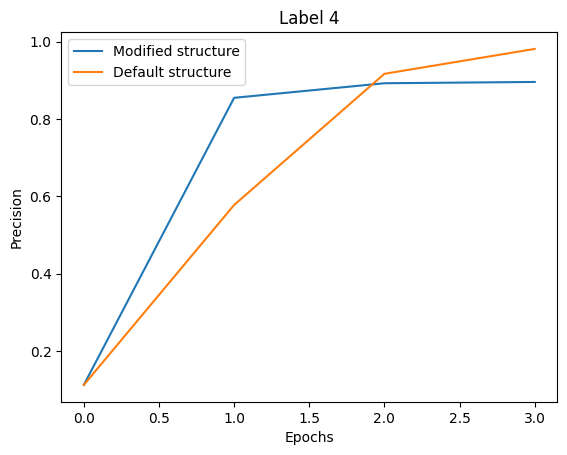

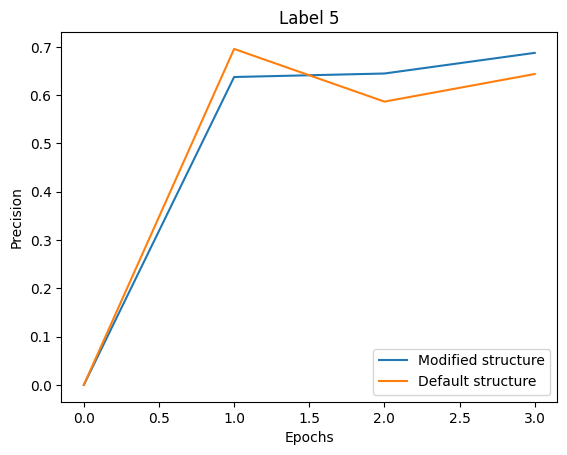

In [45]:
# Plot original and new precision
for i in range(6):
  plt.plot(n_precision_np[:, i], label="Modified structure")
  plt.plot(precision_np[:, i], label="Default structure")
  plt.xlabel("Epochs")
  plt.ylabel("Precision")
  plt.title(f"Label {i}")
  plt.legend()
  plt.show()

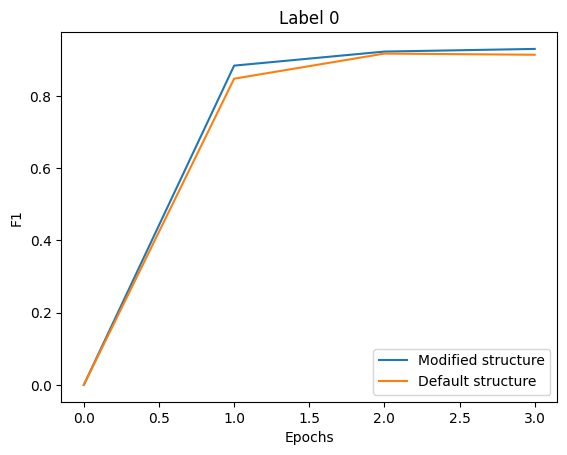

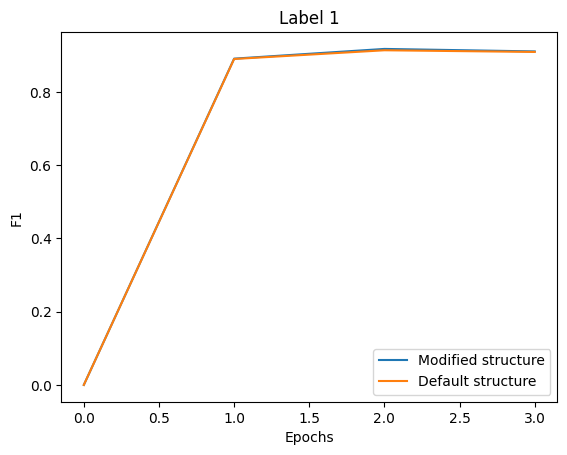

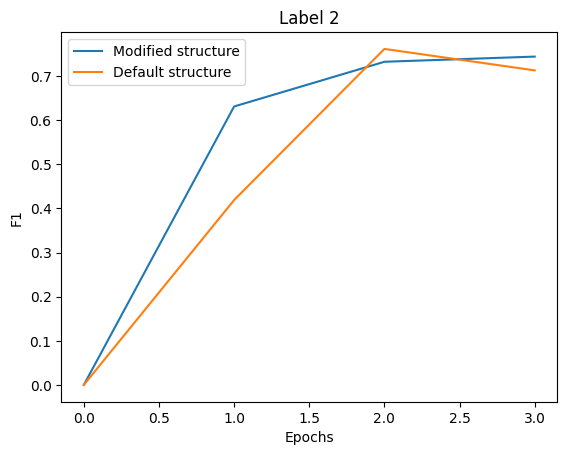

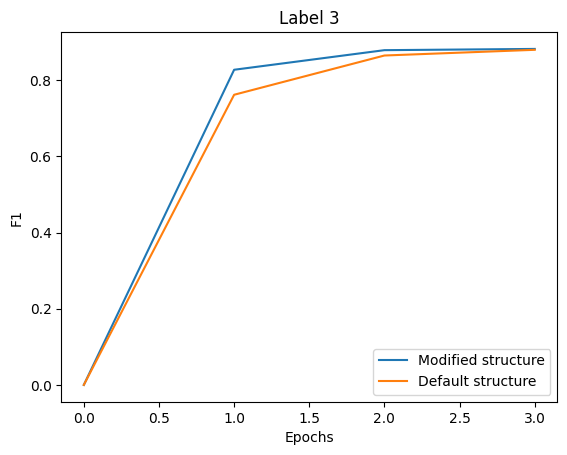

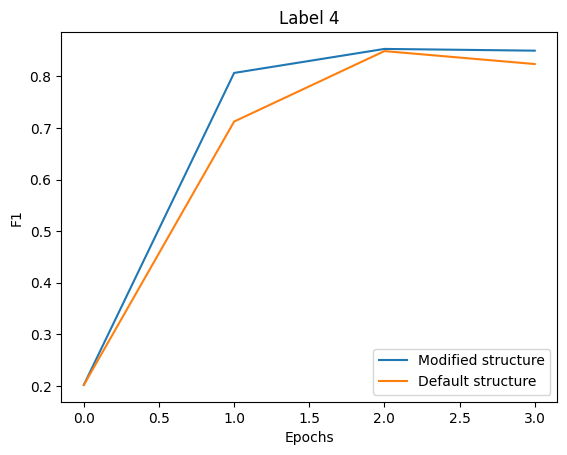

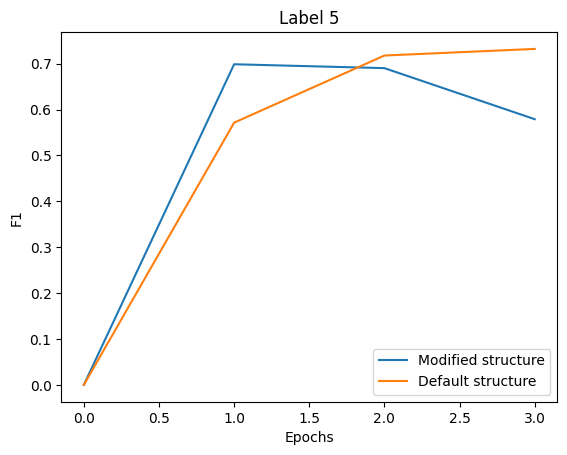

In [46]:
# Plot original and new F1
for i in range(6):
  plt.plot(n_f1_np[:, i], label="Modified structure")
  plt.plot(f1_np[:, i], label="Default structure")
  plt.xlabel("Epochs")
  plt.ylabel("F1")
  plt.title(f"Label {i}")
  plt.legend()
  plt.show()

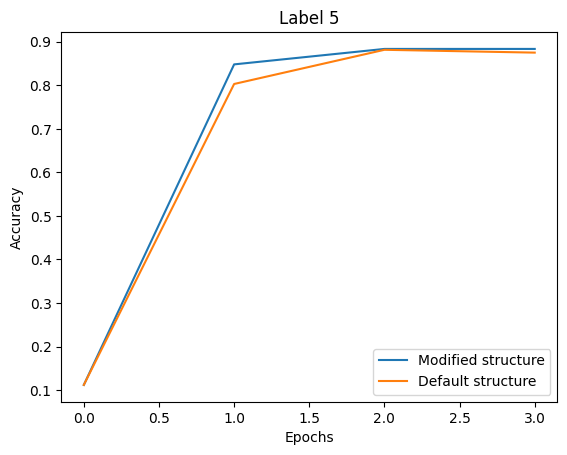

In [47]:
# Plot original and new accuracy
plt.plot(n_acc_np, label="Modified structure")
plt.plot(acc_np, label="Default structure")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(f"Label {i}")
plt.legend()
plt.show()